In [1]:
# Importing 
%load_ext autoreload
%autoreload 2
import os 
import sys
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

# Finding the root directory 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import src.utils.file_utils as fu 
import src.helpers.feature_engineering_helper as feh

cfg_schema = fu.load_config("schema")
cfg_feature_engineering = fu.load_config("feature_engineering")["feature_engineering"]

In [2]:
# Reading the Processed data set 
df = fu.load_parquet("hmda_2024_model")
train_index_path = os.path.join(project_root, 'data', 'processed', 'train_index.csv')
train_index = pd.read_csv(train_index_path)
train_data = df.loc[train_index['index']]
train_data = train_data.sample(frac=0.005, random_state=42)

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [3]:
# Log transform skewed continuous features prior to scaling
train_data = feh.log_transform_skewed_features(train_data)

In [4]:
# Loading the scaler and scaling the numerical values
numeric_cols = ['loan_amount', 'income', 'combined_loan_to_value_ratio', 'loan_term', 'intro_rate_period', 'prepayment_penalty_term',
                'property_value', 'loan_to_income_ratio', 'debt_to_income_ratio_60100_x_loan_to_income_ratio', 'debt_to_income_ratio_5060_x_loan_to_income_ratio', 'debt_to_income_ratio_4850_x_loan_to_income_ratio', 'debt_to_income_ratio_4547_x_loan_to_income_ratio']
scaler = joblib.load(os.path.join(project_root, 'models', 'scaler.pkl'))
df_scaled = scaler.transform(df[numeric_cols])
scaled_df = pd.DataFrame(df_scaled, columns=numeric_cols)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
scaled_df_imp = imputer.fit_transform(scaled_df)
df_numerical = pd.DataFrame(scaled_df_imp, columns = numeric_cols)

In [5]:
# Loading the OHE variables
ohe_cols = [col for col in df.columns
           if col not in numeric_cols and df[col].nunique() <= 2]
df_ohe = df[ohe_cols]
cluster_df = pd.concat([df_numerical, df_ohe], axis = 1)

# Clustering with Entire Dataset/ Features

In [6]:
# Minibatch K-Means
sample_df = cluster_df.sample(n=250000, random_state = 42)

k_range = range(2,15)
elbow_scores = []
for k in k_range:
    mbk = MiniBatchKMeans(n_clusters = k, batch_size =50000, random_state = 42)
    mbk.fit(sample_df)
    elbow_scores.append(mbk.inertia_)

In [7]:
# Minibatch Silhouette Scores 
sample_df = cluster_df.sample(n=85000, random_state = 42)
sil_scores = []
sil_k_range = range(2,15)
for k in sil_k_range:
    mbk = MiniBatchKMeans(n_clusters = k, batch_size =20000, random_state = 42)
    mbk.fit(sample_df)
    sil_scores.append(silhouette_score(sample_df, mbk.labels_))

Text(0.5, 1.0, 'Elbow Method for KMeans')

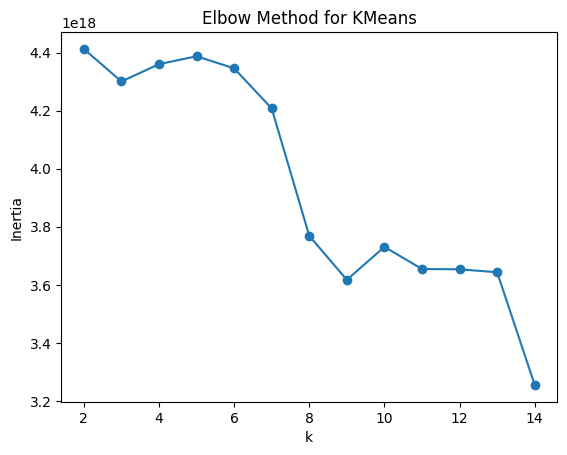

In [8]:
# Plotting Elbow Method 
plt.plot(k_range, elbow_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")

Text(0.5, 1.0, 'Silhouette Scores vs k')

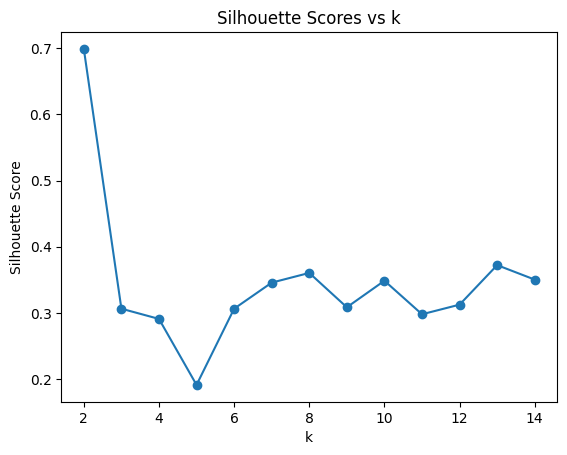

In [9]:
# Plotting Silhouette Method
plt.plot(sil_k_range, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores vs k")

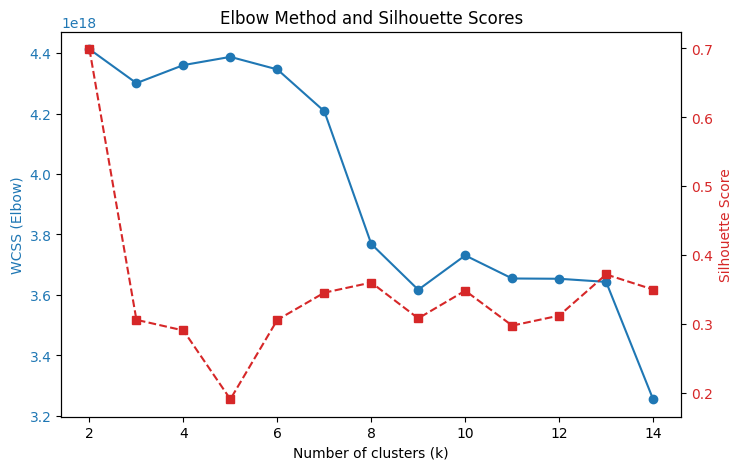

In [10]:
fig, ax1 = plt.subplots(figsize = (8,5))
color1 = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('WCSS (Elbow)', color=color1)
ax1.plot(k_range, elbow_scores, marker='o', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for silhouette scores
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(sil_k_range, sil_scores, marker='s', linestyle='--', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
plt.title('Elbow Method and Silhouette Scores')

# Saving plot
elbow_sil_plot_path = os.path.join(project_root, 'reports','figures', 'elbow_silhouette_plot.png')
os.makedirs(os.path.dirname(elbow_sil_plot_path), exist_ok=True)
plt.savefig(elbow_sil_plot_path, dpi=300, bbox_inches='tight')

In [11]:
# Based on the above plot we chose a k of 8 because it balances the two models. 

In [12]:
# Training it on the entire dataset
k = 9
batch_size = 50000

mbk = MiniBatchKMeans(n_clusters = k, batch_size = batch_size, random_state=42)
cluster_df = cluster_df.astype(np.float32)

n_rows = cluster_df.shape[0]
for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    mbk.partial_fit(cluster_df[start:end])

cluster_ids = np.zeros(len(cluster_df), dtype=np.int32)
for start in range(0,len(cluster_df), batch_size):
    end = start + batch_size
    batch = cluster_df.iloc[start:end].astype(np.float32)
    cluster_ids[start:end] = mbk.predict(batch)
    
df['cluster_id'] = cluster_ids


In [13]:
# Saving the data Parquet 
cluster_parquet_path = os.path.join(project_root, 'data','processed', 'hmda_2024_model_with_clusters.parquet')
os.makedirs(os.path.dirname(cluster_parquet_path), exist_ok=True)
df.to_parquet(cluster_parquet_path, index=False)

In [14]:
#Cluster Summary Table 
cluster_summary = df.groupby('cluster_id').agg({
    'loan_amount' : ['mean', 'std'],
    'income' : ['mean', 'std'],
    'combined_loan_to_value_ratio' : ['mean', 'std'],
    'loan_term': ['mean', 'std'],
    'intro_rate_period': ['mean', 'std'],
    'prepayment_penalty_term': ['mean',  'std'], 
    'property_value': ['mean', 'std']})

cluster_summary.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col 
                           for col in cluster_summary.columns]
cluster_summary = cluster_summary.reset_index()
cluster_summary = cluster_summary.round(4)

ohe_cols = [col for col in df.columns
           if col not in numeric_cols and df[col].nunique() <= 2]
cluster_proportions = df.groupby('cluster_id')[ohe_cols].mean().reset_index()
cluster_proportions = cluster_proportions.round(4)

cluster_summary = cluster_summary.merge(cluster_proportions, on='cluster_id', how='left')

# Saving CSV File
cluster_csv_path = os.path.join(project_root, 'reports','tables', 'cluster_summary.csv')
os.makedirs(os.path.dirname(cluster_csv_path), exist_ok=True)
cluster_summary.to_csv(cluster_csv_path, index=False)
    

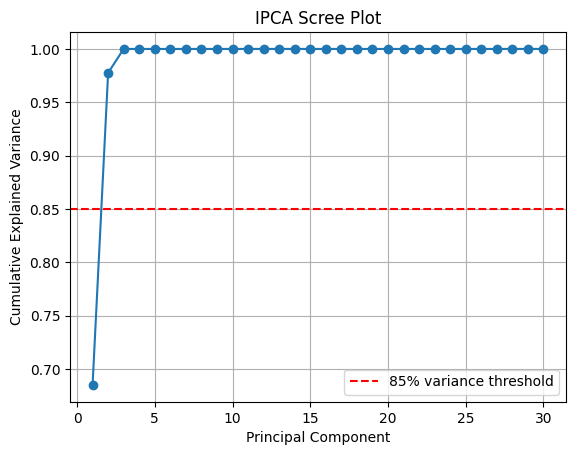

In [15]:
# Creating a temporary PCA with all variable s
from sklearn.decomposition import IncrementalPCA
n_components = 30
batch_size = 50000
ipca = IncrementalPCA(n_components=n_components, batch_size = batch_size)
ipca.fit(cluster_df)
plt.plot(range(1,ipca.n_components_ +1), ipca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('IPCA Scree Plot')
plt.grid(True)
plt.axhline(y=0.85, color='r', linestyle = '--', label = '85% variance threshold')
plt.legend()

In [16]:
# Training the IPCA with the correct number of components.
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size = batch_size)
ipca.fit(cluster_df)

,n_components,2
,whiten,False
,copy,True
,batch_size,50000


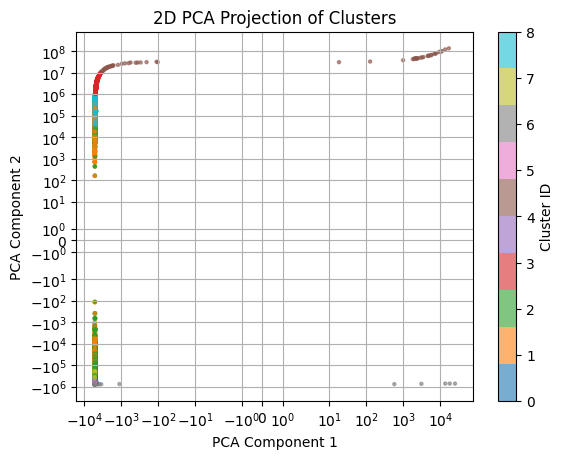

In [17]:
# Cluster PCA Plot
sample_df = df.sample(n=50_000, random_state=42)
pca_features = list(cluster_df.columns)
sample_features = sample_df[pca_features]

#pca = joblib.load(os.path.join(project_root, 'models', 'ipca.pkl'))
pca_data = ipca.transform(sample_features)
pca_2d = pca_data[:,:2]

plt.scatter(pca_2d[:,0], pca_2d[:,1], c = sample_df['cluster_id'], cmap = 'tab10', s = 5, alpha = 0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("2D PCA Projection of Clusters")
plt.colorbar(label='Cluster ID')
plt.grid(True)

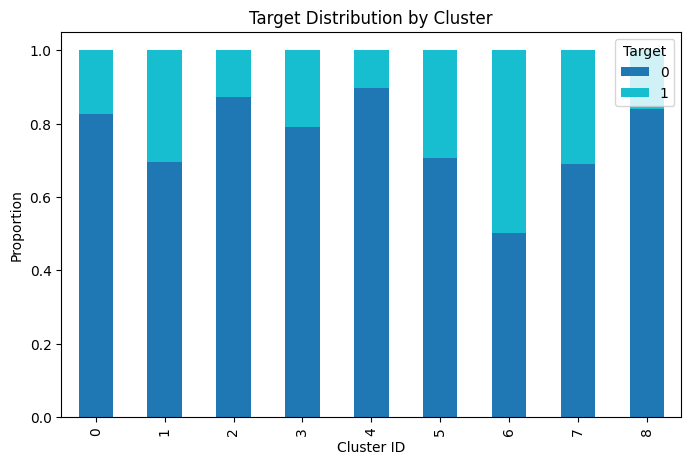

In [18]:
cluster_target_summary = sample_df.groupby('cluster_id')['denied_flag'].value_counts(normalize=True).unstack()
cluster_target_summary.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab10')
plt.title("Target Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Proportion")
plt.legend(title="Target")
plt.show()

In [19]:
# Clustering based on all features does not seem to get any meaninful results. The proportion of each cluster in relation to the target variable 
# are close. 

In [20]:
# Therefore we will try clustering based on subsets of features.

# Clustering based on Applicant/ CoApplicant Financial Features

Text(0.5, 1.0, 'Elbow Method for KMeans')

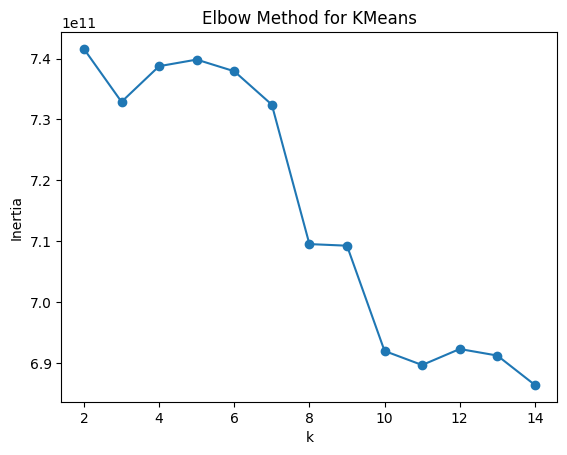

In [22]:
# Clustering based on the applicant/coapplicant financial features.

applicant_financial_columns = ['income', 'debt_to_income_ratio_NA', 'debt_to_income_ratio_20–30',
                               'debt_to_income_ratio_3036', 'debt_to_income_ratio_5060',
                               'debt_to_income_ratio_not_applicable', 'debt_to_income_ratio_other',
                               'applicant_credit_scoring_model_NA', 'applicant_credit_scoring_model_known_model', 
                               'applicant_credit_scoring_model_FICO_Risk_Score_Classic_04', 'applicant_credit_scoring_model_Other_credit_scoring_model', 
                               'applicant_credit_scoring_model_Not_applicable', 'applicant_credit_scoring_model_other', 
                               'co_applicant_credit_scoring_model_NA', 'co_applicant_credit_scoring_model_known_model', 
                               'co_applicant_credit_scoring_model_FICO_Risk_Score_Classic_04', 'co_applicant_credit_scoring_model_Other_credit_scoring_model',
                               'co_applicant_credit_scoring_model_Not_applicable', 'co_applicant_credit_scoring_model_other', 
                               'applicant_credit_scoring_model_exempt', 'co_applicant_credit_scoring_model_exempt']
applicant_financial_cluster_df = cluster_df[applicant_financial_columns]

sample_df = applicant_financial_cluster_df.sample(n=250000, random_state = 42)
k_range = range(2,15)
elbow_appfin_scores = []
for k in k_range:
    mbk = MiniBatchKMeans(n_clusters = k, batch_size =50000, random_state = 42)
    mbk.fit(sample_df)
    elbow_appfin_scores.append(mbk.inertia_)

plt.plot(k_range, elbow_appfin_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")

In [23]:
# Training it on the entire dataset
k = 10
batch_size = 50000

mbk = MiniBatchKMeans(n_clusters = k, batch_size = batch_size, random_state=42)
appfin_cluster_df = applicant_financial_cluster_df.astype(np.float32)

n_rows = appfin_cluster_df.shape[0]
for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    mbk.partial_fit(appfin_cluster_df[start:end])

appfin_cluster_ids = np.zeros(len(appfin_cluster_df), dtype=np.int32)
for start in range(0,len(appfin_cluster_df), batch_size):
    end = start + batch_size
    batch = appfin_cluster_df.iloc[start:end].astype(np.float32)
    appfin_cluster_ids[start:end] = mbk.predict(batch)
    
df['app_fincluster_id'] = appfin_cluster_ids

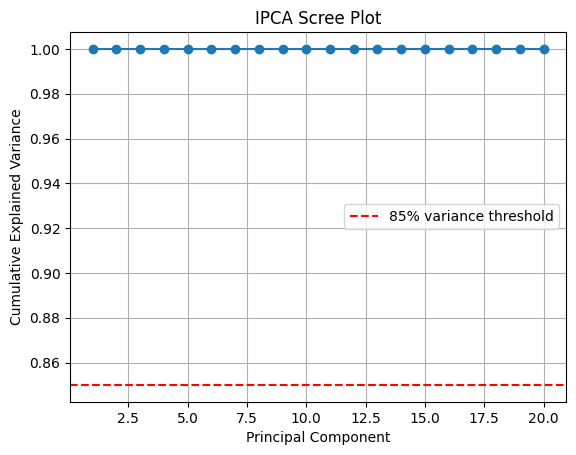

In [24]:
# Creating a temporary PCA with applicant financial features
from sklearn.decomposition import IncrementalPCA
n_components = 20
batch_size = 50000
ipca_appfin = IncrementalPCA(n_components=n_components, batch_size = batch_size)
ipca_appfin.fit(appfin_cluster_df)
plt.plot(range(1,ipca_appfin.n_components_ +1), ipca_appfin.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('IPCA Scree Plot')
plt.grid(True)
plt.axhline(y=0.85, color='r', linestyle = '--', label = '85% variance threshold')
plt.legend()

In [25]:
# Training the IPCA on the correct number of components.
n_components = 2
ipca_appfin = IncrementalPCA(n_components=n_components, batch_size = batch_size)
ipca_appfin.fit(appfin_cluster_df)

,n_components,2
,whiten,False
,copy,True
,batch_size,50000


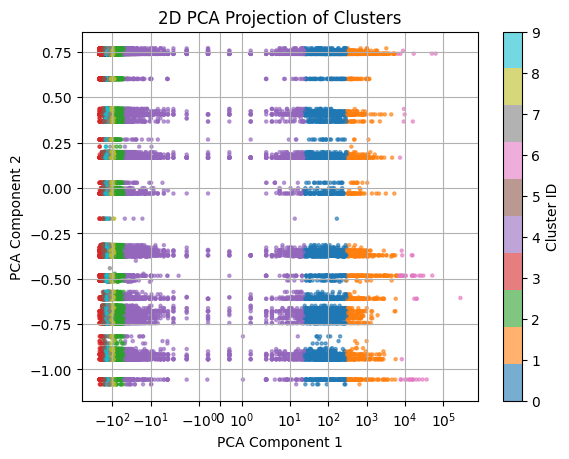

In [26]:
# Cluster PCA Plot
sample_df = df.sample(n=50_000, random_state=42)
appfin_pca_features = list(applicant_financial_columns)
appfin_sample_features = sample_df[appfin_pca_features]

appfin_pca_data = ipca_appfin.transform(appfin_sample_features)
appfin_pca_2d = appfin_pca_data[:,:2]

plt.scatter(appfin_pca_2d[:,0], appfin_pca_2d[:,1], c = sample_df['app_fincluster_id'], cmap = 'tab10', s = 5, alpha = 0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xscale('symlog')
#plt.yscale('symlog')
plt.title("2D PCA Projection of Clusters")
plt.colorbar(label='Cluster ID')
plt.grid(True)

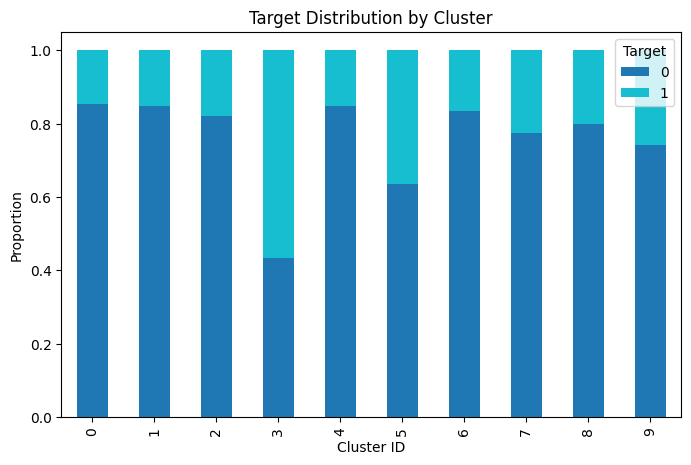

In [27]:
# Looking at the clusters in relation to the target variables.
cluster_target_summary = sample_df.groupby('app_fincluster_id')['denied_flag'].value_counts(normalize=True).unstack()
cluster_target_summary.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab10')
plt.title("Target Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Proportion")
plt.legend(title="Target")
plt.show()

In [28]:
# These could be meaningful clusters. Especially cluster 3 which seems to have a lot higher acceptance rate than the other clusters.

# Clustering Based on Loan Structure

Text(0.5, 1.0, 'Elbow Method for KMeans')

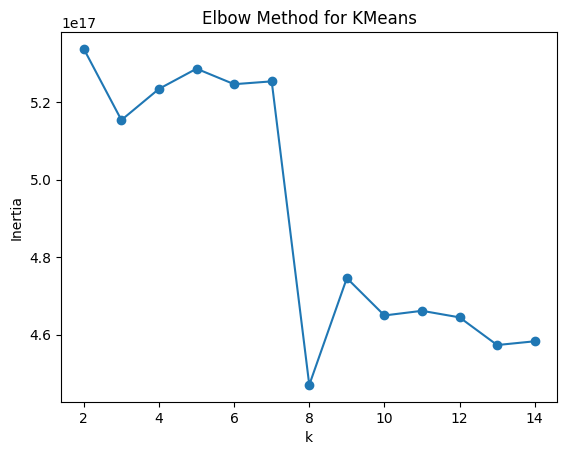

In [29]:
# Clustering based on the loan structure columns.

loan_structure_columns = ['loan_amount', 'loan_term', 'combined_loan_to_value_ratio', 'intro_rate_period', 'prepayment_penalty_term', 
                          'interest_only_payment_NA', 'interest_only_payment_True', 'interest_only_payment_False', 'interest_only_payment_other', 
                          'negative_amortization_NA', 'negative_amortization_True', 'negative_amortization_False', 'negative_amortization_other',
                          'negative_amortization_exempt', 'open_end_line_of_credit_NA', 'open_end_line_of_credit_True',
                          'open_end_line_of_credit_False', 'open_end_line_of_credit_other', 'other_non_amortizing_features_NA', 
                          'other_non_amortizing_features_True', 'other_non_amortizing_features_False', 'other_non_amortizing_features_other',
                          'reverse_mortgage_NA', 'reverse_mortgage_True', 'reverse_mortgage_False', 'reverse_mortgage_other', 'loan_type_NA', 
                          'loan_type_conventional', 'loan_type_va', 'loan_type_other', 'loan_purpose_NA', 'loan_purpose_home_purchase', 
                          'loan_purpose_home_improve', 'loan_purpose_refi', 'loan_purpose_other', 'loan_purpose_not_applicable','preapproval_NA', 
                          'preapproval_True', 'preapproval_False', 'preapproval_other', 'lien_status_NA', 'lien_status_first', 
                          'lien_status_subordinate', 'lien_status_other']


loanstr_cluster_df = cluster_df[loan_structure_columns]

sample_df = loanstr_cluster_df.sample(n=250000, random_state = 42)
k_range = range(2,15)
elbow_loanstr_scores = []
for k in k_range:
    mbk = MiniBatchKMeans(n_clusters = k, batch_size =50000, random_state = 42)
    mbk.fit(sample_df)
    elbow_loanstr_scores.append(mbk.inertia_)

plt.plot(k_range, elbow_loanstr_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")

In [30]:
# Training it on the entire dataset
k = 8
batch_size = 50000

mbk = MiniBatchKMeans(n_clusters = k, batch_size = batch_size, random_state=42)
loanstr_cluster_df = loanstr_cluster_df.astype(np.float32)

n_rows = loanstr_cluster_df.shape[0]
for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    mbk.partial_fit(loanstr_cluster_df[start:end])

loanstr_cluster_ids = np.zeros(len(loanstr_cluster_df), dtype=np.int32)
for start in range(0,len(loanstr_cluster_df), batch_size):
    end = start + batch_size
    batch = loanstr_cluster_df.iloc[start:end].astype(np.float32)
    loanstr_cluster_ids[start:end] = mbk.predict(batch)
    
df['loanstr_cluster_id'] = loanstr_cluster_ids

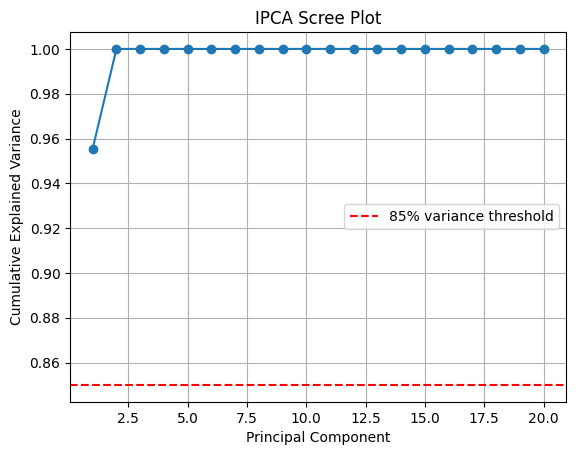

In [31]:
# Creating a temporary PCA with applicant financial features
from sklearn.decomposition import IncrementalPCA
n_components = 20
batch_size = 50000
ipca_loanstr = IncrementalPCA(n_components=n_components, batch_size = batch_size)
ipca_loanstr.fit(loanstr_cluster_df)
plt.plot(range(1,ipca_loanstr.n_components_ +1), ipca_loanstr.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('IPCA Scree Plot')
plt.grid(True)
plt.axhline(y=0.85, color='r', linestyle = '--', label = '85% variance threshold')
plt.legend()

In [32]:
# Training the IPCA on the correct number of components 
n_components = 2
ipca_loanstr = IncrementalPCA(n_components=n_components, batch_size = batch_size)
ipca_loanstr.fit(loanstr_cluster_df)

,n_components,2
,whiten,False
,copy,True
,batch_size,50000


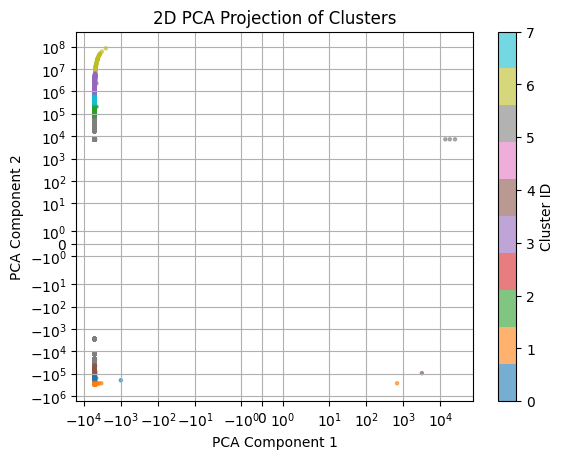

In [33]:
# Cluster PCA Plot
sample_df = df.sample(n=50_000, random_state=42)
loanstr_pca_features = list(loan_structure_columns)
loanstr_sample_features = sample_df[loanstr_pca_features]

loanstr_pca_data = ipca_loanstr.transform(loanstr_sample_features)
loanstr_pca_2d = loanstr_pca_data[:,:2]

plt.scatter(loanstr_pca_2d[:,0], loanstr_pca_2d[:,1], c = sample_df['loanstr_cluster_id'], cmap = 'tab10', s = 5, alpha = 0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("2D PCA Projection of Clusters")
plt.colorbar(label='Cluster ID')
plt.grid(True)

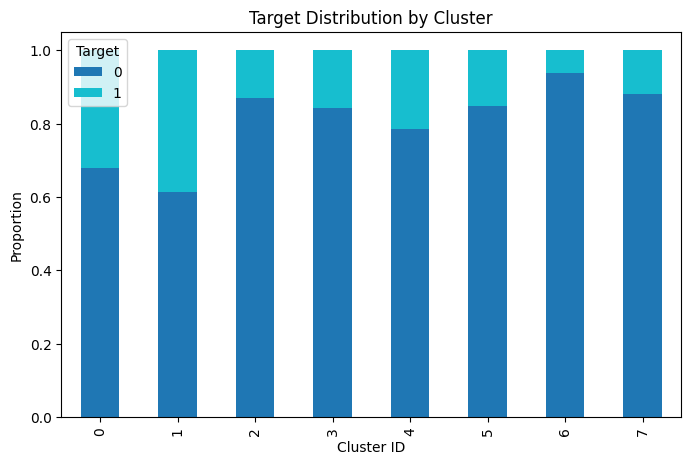

In [34]:
# Looking at the clusters in relation to the target variables.
cluster_target_summary = sample_df.groupby('loanstr_cluster_id')['denied_flag'].value_counts(normalize=True).unstack()
cluster_target_summary.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab10')
plt.title("Target Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Proportion")
plt.legend(title="Target")
plt.show()

In [35]:
# Seemingly non-meaningful clusters.

# CLustering Based on Property Type/ Collateral 

Text(0.5, 1.0, 'Elbow Method for KMeans')

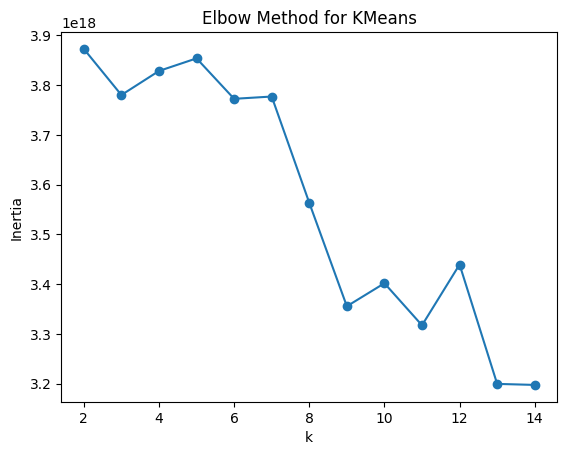

In [36]:
# Clustering based on Property Type and Collateral 
property_columns = ['property_value','construction_method_NA', 'construction_method_site', 'construction_method_manufactured', 
                    'construction_method_other', 'manufactured_home_land_property_interest_NA', 'manufactured_home_land_property_interest_direct', 
                    'manufactured_home_land_property_interest_indirect', 'manufactured_home_land_property_interest_paid_lease', 
                    'manufactured_home_land_property_interest_unpaid_lease', 'manufactured_home_land_property_interest_not_applicable', 
                    'manufactured_home_land_property_interest_other', 'manufactured_home_secured_property_type_NA', 
                    'manufactured_home_secured_property_type_land', 'manufactured_home_secured_property_type_not_land', 
                    'manufactured_home_secured_property_type_not_applicable', 'manufactured_home_secured_property_type_other', 
                    'occupancy_type_NA', 'occupancy_type_primary', 'occupancy_type_secondary','occupancy_type_investment', 'occupancy_type_other']


property_cluster_df = cluster_df[property_columns]

sample_df = property_cluster_df.sample(n=250000, random_state = 42)
k_range = range(2,15)
elbow_property_scores = []
for k in k_range:
    mbk = MiniBatchKMeans(n_clusters = k, batch_size =50000, random_state = 42)
    mbk.fit(sample_df)
    elbow_property_scores.append(mbk.inertia_)

plt.plot(k_range, elbow_property_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")

In [37]:
# Training it on the entire dataset
k = 9
batch_size = 50000

mbk = MiniBatchKMeans(n_clusters = k, batch_size = batch_size, random_state=42)
property_cluster_df = property_cluster_df.astype(np.float32)

n_rows = property_cluster_df.shape[0]
for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    mbk.partial_fit(property_cluster_df[start:end])

property_cluster_ids = np.zeros(len(property_cluster_df), dtype=np.int32)
for start in range(0,len(property_cluster_df), batch_size):
    end = start + batch_size
    batch = property_cluster_df.iloc[start:end].astype(np.float32)
    property_cluster_ids[start:end] = mbk.predict(batch)
    
df['property_cluster_id'] = property_cluster_ids

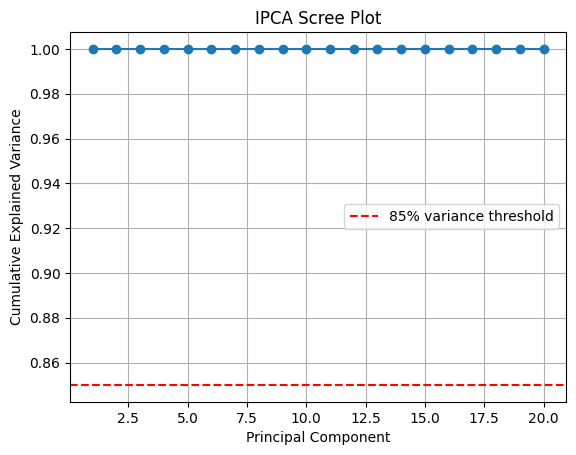

In [38]:
# Creating a temporary PCA with applicant financial features
from sklearn.decomposition import IncrementalPCA
n_components = 20
batch_size = 50000
ipca_property = IncrementalPCA(n_components=n_components, batch_size = batch_size)
ipca_property.fit(property_cluster_df)
plt.plot(range(1,ipca_property.n_components_ +1), ipca_property.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('IPCA Scree Plot')
plt.grid(True)
plt.axhline(y=0.85, color='r', linestyle = '--', label = '85% variance threshold')
plt.legend()

In [39]:
# Training the IPCA on the correct number of components 
n_components = 2
ipca_property = IncrementalPCA(n_components=n_components, batch_size = batch_size)
ipca_property.fit(property_cluster_df)

,n_components,2
,whiten,False
,copy,True
,batch_size,50000


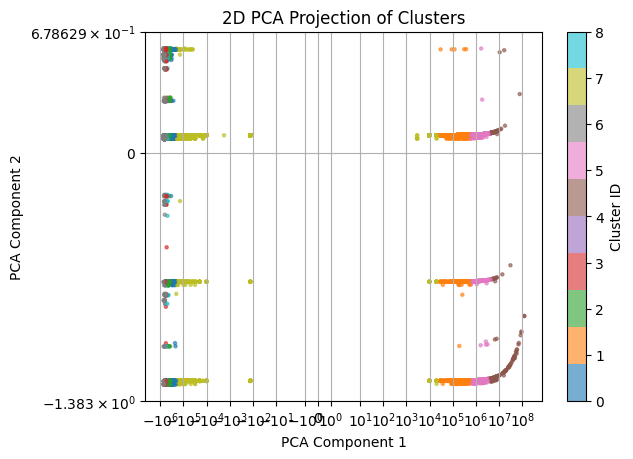

In [40]:
# Cluster PCA Plot
sample_df = df.sample(n=50_000, random_state=42)
property_pca_features = list(property_columns)
property_sample_features = sample_df[property_pca_features]

property_pca_data = ipca_property.transform(property_sample_features)
property_pca_2d = property_pca_data[:,:2]

plt.scatter(property_pca_2d[:,0], property_pca_2d[:,1], c = sample_df['property_cluster_id'], cmap = 'tab10', s = 5, alpha = 0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("2D PCA Projection of Clusters")
plt.colorbar(label='Cluster ID')
plt.grid(True)

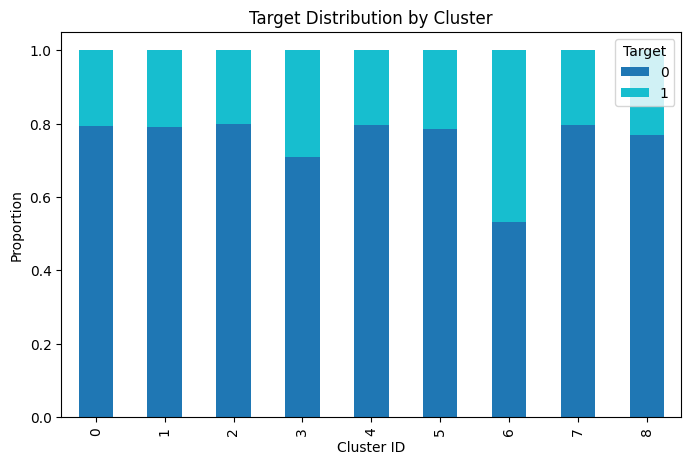

In [41]:
# Looking at the clusters in relation to the target variables.
cluster_target_summary = sample_df.groupby('property_cluster_id')['denied_flag'].value_counts(normalize=True).unstack()
cluster_target_summary.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab10')
plt.title("Target Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Proportion")
plt.legend(title="Target")
plt.show()

In [42]:
# Does not seem to have meaningul clusters. CLuster 6 has a higher degree of accceptance.